In [1]:
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader, Dataset, random_split
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

import pickle
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 8
num_epochs = 30

---

In [3]:
train_fh = open('datasets/lego-train.pickle', 'rb')
test_fh  = open('datasets/lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data  = pickle.load(test_fh)

train_data = [(np.float32(image), label) for image, label in train_data]
test_data  = [(np.float32(image), label) for image, label in test_data]

train_data[0][0].shape

(48, 48, 1)

In [4]:
train_iter = iter(train_data)

image, label = next(train_iter)

image.shape, label

((48, 48, 1), 4)

In [5]:
np.min(image), np.max(image)

(2.0, 255.0)

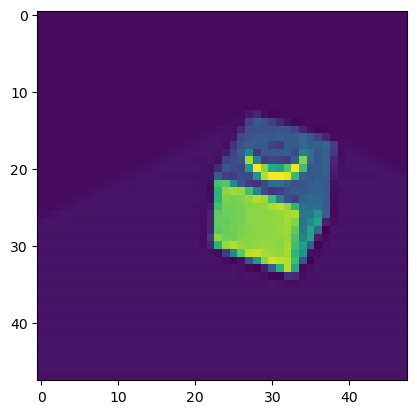

In [6]:
plt.imshow(image.reshape((48, 48, 1)))

In [7]:
def scale(data):
    scaled_data = []
    for images, label in data:
        scaled_data.append((images / 255.0, label))

    return scaled_data

In [8]:
train_data = scale(train_data)
test_data  = scale(test_data)

test_data[0][0].shape

(48, 48, 1)

In [9]:
def get_mean_std(data):
    mean = []
    std  = []
    for images, _ in data:
        mean.append(images.mean(axis=(0, 1)))
        std.append(images.std(axis=(0, 1)))

    mean = np.mean(mean, axis=0)[0]
    std  = np.mean(std, axis=0)[0]

    return mean, std

In [10]:
mean, std = get_mean_std(train_data)
mean, std

(0.121675774, 0.22127292)

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.data      = dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[mean], std=[std])  # Normalize the tensor
])

In [13]:
train_data, val_data = random_split(train_data, [400, 51])
len(train_data), len(val_data)

(400, 51)

In [14]:
train_dataset = CustomDataset(train_data, transform=transform)
val_dataset   = CustomDataset(val_data,   transform=transform)
test_dataset  = CustomDataset(test_data , transform=transform)

In [15]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size = batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle=False)

---

In [16]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=8,  kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=8,  out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.pool  = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc1   = nn.Linear(32*6*6, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

---

In [18]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
)

In [19]:
for i, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {model(inputs).shape}')
    break

input shape: torch.Size([8, 1, 48, 48])
after network shape: torch.Size([8, 10])


In [20]:
num_params = 0
for x in model.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 17,418


In [21]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
def train_one_epoch():
    model.train(True)
    
    running_loss = 0.0
    running_accuracy = 0.0
    
    for batch_index, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs) # shape: [batch_size, 10]
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          running_loss,
                                                          running_accuracy * 100))
        running_loss = 0.0
        running_accuracy = 0.0
    
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(val_loader)
    avg_acc_across_batches = (running_accuracy / len(val_loader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                             avg_acc_across_batches))
    print('***************************************************')
    print()

    return avg_loss_across_batches, avg_acc_across_batches

In [24]:
loss_history = []
acuracy_history = []

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    scores = validate_one_epoch()
    
    loss_history.append(scores[0])
    acuracy_history.append(scores[1])
        
print('Finished Training')

Epoch: 1

Batch 1, Loss: 2.316, Accuracy: 12.5%
Batch 2, Loss: 2.275, Accuracy: 12.5%
Batch 3, Loss: 2.315, Accuracy: 0.0%
Batch 4, Loss: 2.302, Accuracy: 12.5%
Batch 5, Loss: 2.337, Accuracy: 0.0%
Batch 6, Loss: 2.295, Accuracy: 12.5%
Batch 7, Loss: 2.305, Accuracy: 12.5%
Batch 8, Loss: 2.265, Accuracy: 25.0%
Batch 9, Loss: 2.324, Accuracy: 12.5%
Batch 10, Loss: 2.289, Accuracy: 12.5%
Batch 11, Loss: 2.354, Accuracy: 0.0%
Batch 12, Loss: 2.270, Accuracy: 12.5%
Batch 13, Loss: 2.299, Accuracy: 0.0%
Batch 14, Loss: 2.314, Accuracy: 0.0%
Batch 15, Loss: 2.276, Accuracy: 12.5%
Batch 16, Loss: 2.288, Accuracy: 12.5%
Batch 17, Loss: 2.248, Accuracy: 25.0%
Batch 18, Loss: 2.389, Accuracy: 0.0%
Batch 19, Loss: 2.269, Accuracy: 12.5%
Batch 20, Loss: 2.300, Accuracy: 12.5%
Batch 21, Loss: 2.291, Accuracy: 12.5%
Batch 22, Loss: 2.244, Accuracy: 25.0%
Batch 23, Loss: 2.343, Accuracy: 12.5%
Batch 24, Loss: 2.302, Accuracy: 25.0%
Batch 25, Loss: 2.265, Accuracy: 12.5%
Batch 26, Loss: 2.285, Accurac

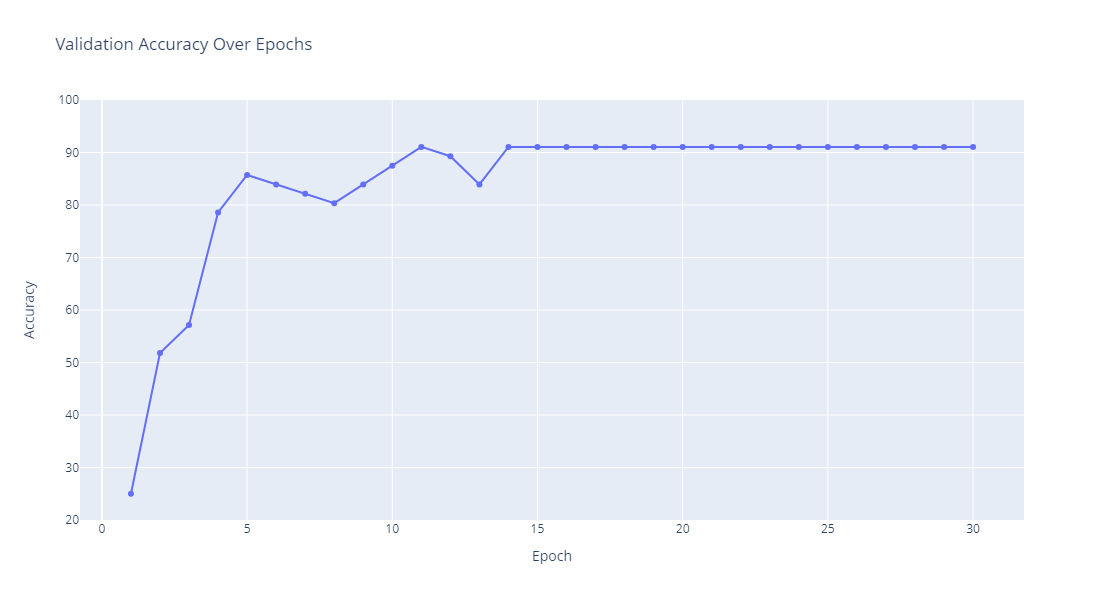

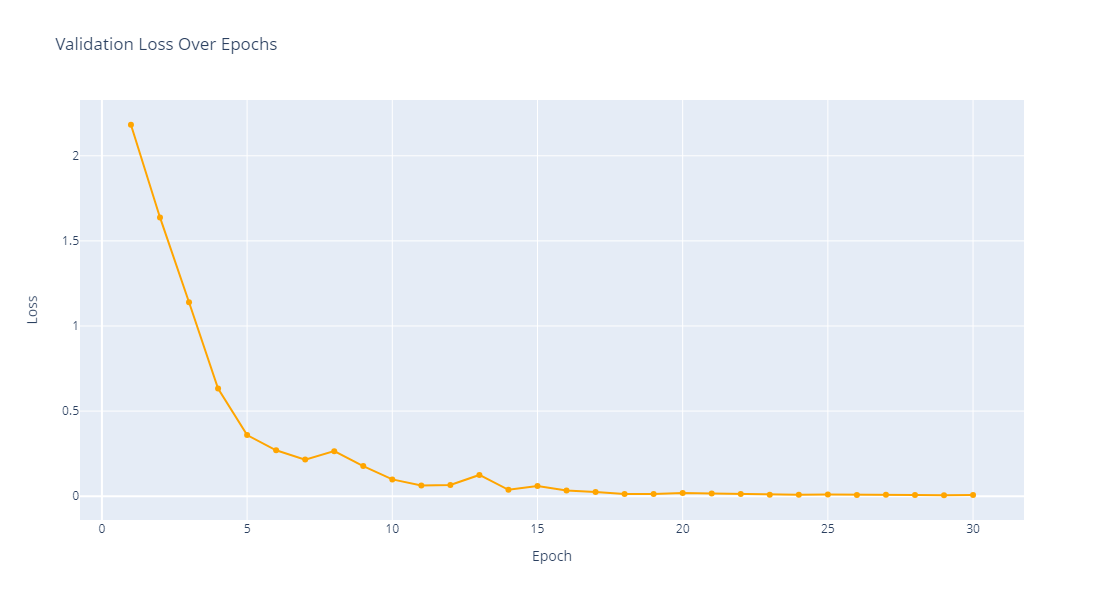

In [28]:
epochs = list(range(1, num_epochs + 1))

fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=acuracy_history, mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(
    title='Validation Accuracy Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    width=800,
    height=600
)
fig.update_yaxes(range=[20.0, 100.0])

fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=epochs, y=loss_history, mode='lines+markers', name='Validation Loss', line=dict(color='orange')))
fig.update_layout(
    title='Validation Loss Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    width=800,
    height=600
)

fig.show()

In [35]:
model.eval()

running_loss = 0.0
running_accuracy = 0.0

for i, data in enumerate(test_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        running_accuracy += torch.sum(preds == labels.data)
        running_loss += loss.item() * inputs.size(0)

test_loss = running_loss / len(test_loader.dataset)
test_accuracy = running_accuracy.double() / len(test_loader.dataset)

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
    test_loss, test_accuracy * 100))

Test Loss: 0.0030, Test Accuracy: 100.00%
